In [258]:
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
from numpy import linalg as LA
import math
from tqdm import tqdm
import random

In [259]:
def normalize(df):
    minn = list()
    diff = list()
    for i in range(len(df[0])):
        minn.append(df[:, i].min())
        diff.append(df[:, i].max() - minn[i])
    for i in range(len(df)):
        for j in range(len(df[i])):
            if diff[j] == 0:
              df[i][j] = 0
            else:
              df[i][j] = (df[i][j] - minn[j]) / diff[j]
    return df

In [260]:
from pandas.core.common import random_state
f = open("1.txt")
m = int(f.readline())
n = int(f.readline())
df = []
for i in range(n):
  df.append(list(map(float, (f.readline().split()))))
df = normalize(np.array(df))
np.random.shuffle(df)
X = [df[i][:-1] for i in range(len(df))]
Y = [df[i][-1] for i in range(len(df))]

n_test = int(f.readline())
df_test = []
for i in range(n_test):
  df_test.append(list(map(float, (f.readline().split()))))
df_test = normalize(np.array(df_test))
np.random.shuffle(df_test)
X_test = np.array([df_test[i][:-1] for i in range(len(df_test))])
Y_test = np.array([df_test[i][-1] for i in range(len(df_test))])


In [261]:
def smape(y, y_real):
  return np.mean(abs(y - y_real) / (abs(y) + abs(y_real)))
def mse(y, y_real):
  return np.mean((y - y_real) ** 2)
def nrmse(y, y_real):
  return np.sqrt(mse(y, y_real)) / np.mean(y_real)

In [262]:
def matrix_psevdo(xs, y, l):
  return np.matmul(np.matmul(
      LA.inv(np.matmul(np.array(xs).T, xs) + (1 / l) * np.eye(len(xs[0]))), 
      np.array(xs).T)
    , y)

In [263]:
max_iter = 2000
eps = 0.0000001

def d_mse(y, pred):
  return 2 * (y - pred)

def part_mse(y, pred):
  return (pred - y) ** 2

def d_smape(y, pred):
  denom = (abs(pred * (pred - y)) * ((abs(pred) + abs(y)) ** 2))
  if denom != 0:
    return (y - pred) * ((abs(pred * y) + pred * y)) / denom
  else:
    return 0

def part_smape(y, pred):
  return abs(pred - y) / ((abs(pred) + abs(y)))


# h - шаг, alpha - скорость затухания (ema dL)
def sgd(xs, y, alpha, h, l, part_fun, d_fun, write_log):
  xs_copy = np.insert(xs, 0, values=np.ones(len(xs)), axis=1)
  attrs = len(xs_copy[0])
  weights = np.random.uniform(-1 / (2 * attrs), 1 / (2 * attrs), attrs)

  if write_log:
    ema_log = [np.mean(np.array([part_fun(np.dot(xs_copy[i], weights), y[i]) for i in range(len(xs_copy))]))]
  else:
    ema_log = []

  d_fun_ema = np.zeros(attrs)

  for i in range(max_iter):
    ind = random.randint(0, len(xs_copy) - 1) 
    xi = np.array(xs_copy[ind])
    yi = y[ind]
    pred = np.dot(weights, xi)
    if write_log:
      er = part_fun(pred, yi)
      ema_log.append(alpha * er + (1 - alpha) * ema_log[-1])
    d_fun_ema = alpha * d_fun(pred, yi) * xi + (1 - alpha) * d_fun_ema
    old_weights = weights
    weights = weights * (1 - h * l) - h * d_fun_ema

    if (np.linalg.norm(weights - old_weights) < eps):
      break

  return weights[1:], ema_log

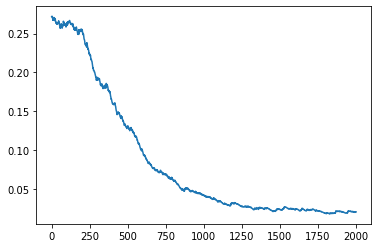

In [264]:
ans, log = sgd(X, Y, 0.01, 0.00001, 0.1, part_mse, d_mse, True)
plt.plot(np.array(list(range(len(log)))), log)

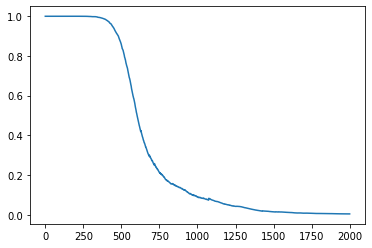

In [265]:
ans, log = sgd(X, Y, 0.01, 0.0001, 0.1, part_smape, d_smape, True)
plt.plot(np.array(list(range(len(log)))), log)

In [266]:
alphas = sorted([np.exp(random.uniform(-9.0, -3.0)) for i in range(10)])
hs = sorted([np.exp(random.uniform(-17.0, -6.0)) for i in range(10)])
ls = sorted([np.exp(random.uniform(-9.0, 0)) for i in range(10)])
inf = 100000000000
best_matrix = [inf, 0]
matrix_log_smape = []
matrix_log_mse = []
best_smape = [inf, 0, 0, 0]
best_mse = [inf, 0, 0, 0]

for l in ls:
    for h in hs:
        for a in alphas:
            ans, _ = sgd(X, Y, a, h, l, part_smape, d_smape, False)
            ys = np.array([np.dot(ans, X_test[i]) for i in range(len(X_test))])
            res = smape(Y_test, ys)
            if res < best_smape[0]:
                best_smape = [res, a, h, l]
            ans, _ = sgd(X, Y, a, h, l, part_mse, d_mse, False)
            ys = np.array([np.dot(ans, X_test[i]) for i in range(len(X_test))])
            res = mse(Y_test, ys)
            if res < best_mse[0]:
                best_mse = [res, a, h, l]
    ans = matrix_psevdo(X, Y, l)
    ys = np.array([np.dot(ans, X_test[i]) for i in range(len(X_test))])
    res = smape(Y_test, ys)
    if res < best_matrix[0]:
        best_matrix = [res, l]
    matrix_log_smape.append(res)
    res = mse(Y_test, ys)
    matrix_log_mse.append(res)

In [267]:
print(best_matrix)
print(best_mse)
print(best_smape)

[0.02452453230702902, 0.17062604559544203]
[0.0007549692424971214, 0.008734548083118151, 0.00024451824185733846, 0.00037918390917219527]
[0.009471928088457308, 0.021925557847977218, 0.00024451824185733846, 0.02156401157479709]


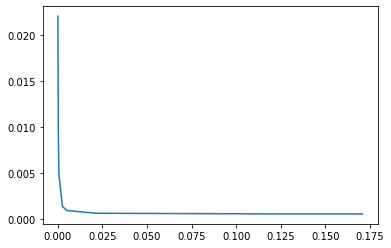

In [268]:
plt.plot(ls, matrix_log_mse)

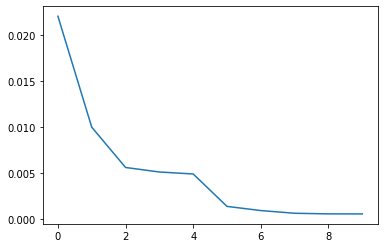

In [269]:
plt.plot(np.array(list(range(len(matrix_log_mse)))), matrix_log_mse)

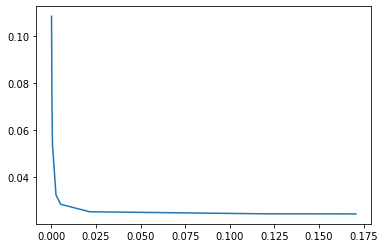

In [270]:
plt.plot(ls, matrix_log_smape)

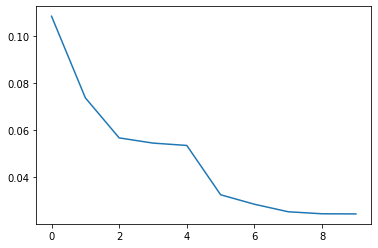

In [271]:
plt.plot(np.array(list(range(len(matrix_log_smape)))), matrix_log_smape)

In [273]:
ans, _ = sgd(X, Y, best_smape[1], best_smape[2], best_smape[3], part_smape, d_smape, False)
ys = np.array([np.dot(ans, X_test[i]) for i in range(len(X_test))])
print('SMAPE smape-based sgd', smape(ys, Y_test))
print('NRMSE smape-based sgd', nrmse(ys, Y_test))

ans, _ = sgd(X, Y, best_mse[1], best_mse[2], best_mse[3], part_mse, d_mse, False)
ys = np.array([np.dot(ans, X_test[i]) for i in range(len(X_test))])
print('SMAPE mse-based sgd', smape(ys, Y_test))
print('NRMSE mse-based sgd', nrmse(ys, Y_test))

ans = matrix_psevdo(X, Y, best_matrix[1])
ys = np.array([np.dot(ans, X_test[i]) for i in range(len(X_test))])
print('SMAPE matrix', smape(ys, Y_test))
print('NRMSE matrix', nrmse(ys, Y_test))

SMAPE smape-based sgd 0.020053611094676918
NRMSE smape-based sgd 0.03588534056422354
SMAPE mse-based sgd 0.027287226074446266
NRMSE mse-based sgd 0.049761188960996086
SMAPE matrix 0.02452453230702902
NRMSE matrix 0.039699834290968454
